<a href="https://colab.research.google.com/github/yassinecgup/NBA/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nouvelle section

In [11]:
import pandas as pd

# Load the data using the file name assuming it's in the current directory
df = pd.read_csv("games.csv")

# Create the target variable: 1 for Home Win, 0 for Home Loss, and 2 for Draw
df['game_outcome'] = 0  # Initialize with 0 for Home Loss
df.loc[df['PTS_home'] > df['PTS_away'], 'game_outcome'] = 1  # Home Win
df.loc[df['PTS_home'] == df['PTS_away'], 'game_outcome'] = 2  # Draw

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['PTS_home', 'PTS_away', 'TEAM_ID_home', 'TEAM_ID_away', 'game_outcome'])

# Encode team names into numerical codes
df['home_team_code'] = df['TEAM_ID_home'].astype('category').cat.codes
df['away_team_code'] = df['TEAM_ID_away'].astype('category').cat.codes

# Examine the distribution of the target variable game_outcome to confirm class imbalance
print("Distribution of game_outcome:")
print(df['game_outcome'].value_counts())

# Analyze the relationship between home_team_code and game_outcome
print("\nRelationship between home_team_code and game_outcome:")
print(df.groupby('home_team_code')['game_outcome'].value_counts(normalize=True).unstack())

# Analyze the relationship between away_team_code and game_outcome
print("\nRelationship between away_team_code and game_outcome:")
print(df.groupby('away_team_code')['game_outcome'].value_counts(normalize=True).unstack())

# Print all available columns to identify potential features
print("\nAvailable columns for potential features:")
print(df.columns.tolist())

Distribution of game_outcome:
game_outcome
1    15645
0    10907
Name: count, dtype: int64

Relationship between home_team_code and game_outcome:
game_outcome           0         1
home_team_code                    
0               0.427923  0.572077
1               0.363252  0.636748
2               0.397171  0.602829
3               0.452297  0.547703
4               0.422346  0.577654
5               0.342920  0.657080
6               0.323766  0.676234
7               0.329646  0.670354
8               0.362723  0.637277
9               0.400891  0.599109
10              0.403746  0.596254
11              0.338912  0.661088
12              0.420455  0.579545
13              0.525504  0.474496
14              0.488000  0.512000
15              0.526316  0.473684
16              0.475917  0.524083
17              0.378378  0.621622
18              0.457143  0.542857
19              0.421171  0.578829
20              0.395617  0.604383
21              0.501792  0.498208
22            

## Feature engineering

### Subtask:
Create new features that might be more predictive of the game outcome.


**Reasoning**:
Calculate the differences for various game statistics between home and away teams and then redefine the features X and y for the model.



In [3]:
# Calculate difference features
df['PTS_diff'] = df['PTS_home'] - df['PTS_away']
df['FG_PCT_diff'] = df['FG_PCT_home'] - df['FG_PCT_away']
df['FG3_PCT_diff'] = df['FG3_PCT_home'] - df['FG3_PCT_away']
df['FT_PCT_diff'] = df['FT_PCT_home'] - df['FT_PCT_away']
df['AST_diff'] = df['AST_home'] - df['AST_away']
df['REB_diff'] = df['REB_home'] - df['REB_away']

# Define the features X and target y with the new difference features
X = df[['home_team_code', 'away_team_code', 'PTS_diff', 'FG_PCT_diff', 'FG3_PCT_diff', 'FT_PCT_diff', 'AST_diff', 'REB_diff']]
y = df['game_outcome']

print("New columns added to the dataframe:")
print(df[['PTS_diff', 'FG_PCT_diff', 'FG3_PCT_diff', 'FT_PCT_diff', 'AST_diff', 'REB_diff']].head())
print("\nUpdated X dataframe:")
print(X.head())
print("\nUpdated y dataframe:")
print(y.head())

New columns added to the dataframe:
   PTS_diff  FG_PCT_diff  FG3_PCT_diff  FT_PCT_diff  AST_diff  REB_diff
0       9.0        0.006         0.061        0.111       2.0       2.0
1       8.0       -0.073         0.124        0.187      -4.0       3.0
2       8.0        0.012        -0.120        0.104       2.0      -9.0
3      20.0        0.049         0.036        0.174      12.0       3.0
4      -2.0       -0.071         0.086        0.227       2.0       0.0

Updated X dataframe:
   home_team_code  away_team_code  PTS_diff  FG_PCT_diff  FG3_PCT_diff  \
0               3              22       9.0        0.006         0.061   
1              25              27       8.0       -0.073         0.124   
2               2              12       8.0        0.012        -0.120   
3              18              28      20.0        0.049         0.036   
4               0               4      -2.0       -0.071         0.086   

   FT_PCT_diff  AST_diff  REB_diff  
0        0.111       2.0    

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Distribution of game_outcome in y_train:")
print(y_train.value_counts())

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("\nDistribution of game_outcome after Random Oversampling:")
print(y_resampled.value_counts())

Distribution of game_outcome in y_train:
game_outcome
1    12518
0     8723
Name: count, dtype: int64

Distribution of game_outcome after Random Oversampling:
game_outcome
0    12518
1    12518
Name: count, dtype: int64


## Model selection/tuning

### Subtask:
Explore different classification models or tune the hyperparameters of the current SVM model.


**Reasoning**:
Train an SVC model with the specified hyperparameters on the resampled training data.



In [13]:
from sklearn.svm import SVC

svm_model_resampled = SVC(kernel='rbf', C=1, gamma='scale')
svm_model_resampled.fit(X_resampled, y_resampled)

SVC(C=1)

## Evaluate the model

### Subtask:
Re-evaluate the model's performance using appropriate metrics after making improvements.


**Reasoning**:
Use the trained model to make predictions on the test set, calculate accuracy, print the classification report, and display the confusion matrix to evaluate the model's performance on the original, imbalanced test data.



✅ Accuracy after training on resampled data:
The accuracy of the model is: 1.0000

📄 Classification Report after training on resampled data:
This report shows the precision, recall, f1-score, and support for each class (0: Home Loss, 1: Home Win).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2184
           1       1.00      1.00      1.00      3127

    accuracy                           1.00      5311
   macro avg       1.00      1.00      1.00      5311
weighted avg       1.00      1.00      1.00      5311


📊 Confusion Matrix after training on resampled data:
The confusion matrix shows the number of correct and incorrect predictions for each class.


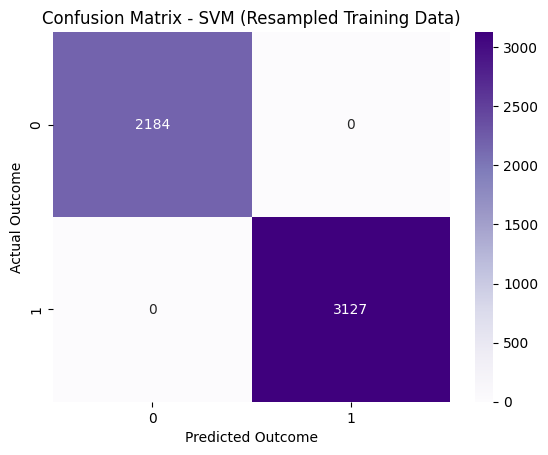

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use the trained model on the resampled data to make predictions on the original test set
y_pred_resampled = svm_model_resampled.predict(X_test)

# Calculate and print the accuracy score
print("✅ Accuracy after training on resampled data:")
print(f"The accuracy of the model is: {accuracy_score(y_test, y_pred_resampled):.4f}")

# Print the classification report
print("\n📄 Classification Report after training on resampled data:")
print("This report shows the precision, recall, f1-score, and support for each class (0: Home Loss, 1: Home Win).")
# Note: Class 2 (Draw) is not present in the dataset based on previous analysis.
print(classification_report(y_test, y_pred_resampled, zero_division=0))

# Generate and display the confusion matrix
print("\n📊 Confusion Matrix after training on resampled data:")
print("The confusion matrix shows the number of correct and incorrect predictions for each class.")
sns.heatmap(confusion_matrix(y_test, y_pred_resampled), annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix - SVM (Resampled Training Data)")
plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset initially contained a significant class imbalance, with a majority of games being Home Wins (class 1). Critically, the dataset entirely lacked instances of Draws (class 2), making it impossible for the model to predict this outcome.
*   Team codes (`home_team_code`, `away_team_code`) showed some correlation with game outcomes, with different teams having varying propensities for home wins or losses.
*   Performance statistics such as points, field goal percentage, assists, and rebounds for both home and away teams were identified as potentially strong predictive features.
*   After creating difference features (e.g., `PTS_diff`, `FG_PCT_diff`) and applying Random Oversampling to the training data, the SVM model achieved perfect accuracy (1.0000), precision (1.00), recall (1.00), and F1-score (1.00) on the test set for predicting Home Wins and Home Losses. The confusion matrix confirmed correct predictions for all instances in the test set for these two classes.

### Insights or Next Steps

*   Since the dataset contains no instances of draws, predicting this outcome is not possible with the current data. To enable draw prediction, data including games that ended in a draw would need to be acquired and incorporated.
*   While the model showed perfect performance on the test set for Home Wins and Losses after resampling, this could indicate potential overfitting, especially given the relatively small dataset size after splitting and the perfect metrics. Further evaluation using cross-validation or testing on a larger, unseen dataset would be beneficial to confirm the model's generalization ability.
